In [1]:
!nvidia-smi 

Thu Jan 23 05:23:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 79%   65C    P2    87W / 250W |   4508MiB / 11019MiB |     52%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 70%   64C    P2   185W / 250W |   4408MiB / 11019MiB |     30%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
!ls

01_CNN.ipynb
SC_CNN_v0.ipynb
SC_CNN_v0.py
SC_CNN_v0_deepSC_Ln_jan20.ipynb
SC_CNN_v0_deepSC_Ln_jan21_nl1_test.ipynb
SC_CNN_v0_deepSC__newbn_jan22.ipynb
SC_CNN_v0_deepSC__nobn_jan23.ipynb
SC_CNN_v0_deepSC_biased321_jan23.ipynb
SC_CNN_v0_deepSC_dilation_jan22.ipynb
SC_CNN_v0_deepSC_dilation_newbn_jan22.ipynb
SC_CNN_v0_deepSC_eqln_jan23.ipynb
SC_CNN_v0_deepSC_eqln_newbn_jan22.ipynb
SC_CNN_v0_deepSC_jan22-b64s.ipynb
Untitled.ipynb
__pycache__
batch_testresult
class_acc_no_size.csv
class_acc_sized.csv
data
data.tar.gz
deepsc_nln_jan21.pt
deepscln_jan20.pt
elastic_test.ipynb
ln_jan20_testresult.csv
ln_jan20_testresult_9only.csv
ln_jan20_testresult_nl1.csv
ln_jan20_testresult_nl1_15-Copy1.csv
ln_jan20_testresult_nl1_15-Copy2.csv
ln_jan20_testresult_nl1_15.csv
ln_jan20_testresult_nl1_30.csv
mnist_4x
mnist_4x.tar.gz
mnist_png.tar
mnist_sized
mnist_sized.tar.gz
mnist_sized_trans.ipynb
nohup.out
parallel.py
sized_val
sized_val.tar.gz
test.csv
testresult_dil_jan22.csv
testresult_dil_nbn_jan22.csv
t

In [3]:
DATA_PATH = ''

In [4]:
import os

In [5]:
#!tar -zxvf 'mnist_4x.tar.gz'

In [6]:
INTERNAL_DATA_PATH = 'mnist_4x/'
INTERNAL_DATA_PATH_MAIN = 'mnist_4x/resized'
INTERNAL_DATA_PATH_OTHER = 'mnist_4x/centered'

In [7]:
import os
import fnmatch
 
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")

In [8]:
from time import sleep
from tqdm import tqdm
for _ in tqdm(range(10)):
    sleep(0.001)

100%|██████████| 10/10 [00:00<00:00, 917.69it/s]


In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

########################################################################
batch_size = 64
########################################################################


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class SizedMnistDataset(Dataset):
    def __init__(self,dir_list,transform=None):
        self.dir_list = dir_list
        self.transform = transform
        
        self.dataset_list = []
        for i in range(len(dir_list)):
            temp_dataset = datasets.ImageFolder(root=self.dir_list[i],transform = self.transform)
            self.dataset_list.append(temp_dataset)
        
    def __len__(self):
        return len(self.dataset_list[0])
    
    def __getitem__(self,idx):
        return self.dataset_list[0][idx],self.dataset_list[1][idx],self.dataset_list[2][idx],self.dataset_list[3][idx],self.dataset_list[4][idx]
    

In [12]:
new_path = ['data/ds2','data/ds3','data/ds4','data/ds5','data/ds6']

train_dataset_path = [x+"/training" for x in new_path]
test_dataset_path = [x+"/testing" for x in new_path]
test_dataset_path

['data/ds2/testing',
 'data/ds3/testing',
 'data/ds4/testing',
 'data/ds5/testing',
 'data/ds6/testing']

In [13]:
#img_size = [729,243,81,27,9]  

transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainMnistDataset = SizedMnistDataset(train_dataset_path,transform)
testMnistDataset = SizedMnistDataset(test_dataset_path,transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=8)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=8)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule1(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 9, stride=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn1_1 = nn.BatchNorm2d(out_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        self.bn1_3 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        self.bn2_3 = nn.BatchNorm2d(out_channels)

        self.bn3_1 = nn.BatchNorm2d(out_channels)
        self.bn3_2 = nn.BatchNorm2d(out_channels)
        self.bn3_3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0])
        x_1_2 = self.conv1(x[1])
        x_1_3 = self.conv1(x[2])

        x_2_1 = self.conv2(x[1])
        x_2_2 = self.conv2(x[2])
        x_2_3 = self.conv2(x[3])

        x_3_1 = self.conv3(x[2])
        x_3_2 = self.conv3(x[3])
        x_3_3 = self.conv3(x[4])

        o_1_1 = torch.stack([x_1_1,x_2_1,x_3_1])
        o_1_1 = self.bn1_1(torch.sum(o_1_1,0))

        o_1_2 = torch.stack([F.conv2d(x[1], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[2], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_1_2 = self.bn1_2(torch.sum(o_1_2,0))

        o_1_3 = self.bn1_3(F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        o_2_1 = torch.stack([x_1_2,x_2_2,x_3_2])
        o_2_1 = self.bn2_1(torch.sum(o_2_1,0))

        o_2_2 = torch.stack([F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[3], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_2_2 = self.bn2_2(torch.sum(o_2_2,0))

        o_2_3 = self.bn2_3(F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        o_3_1 = torch.stack([x_1_3,x_2_3,x_3_3])
        o_3_1 = self.bn3_1(torch.sum(o_3_1,0))

        o_3_2 = torch.stack([F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[4], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_3_2 = self.bn3_2(torch.sum(o_3_2,0))

        o_3_3 = self.bn3_3(F.conv2d(x[4], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        #print(torch.cat([o_1_1,o_1_2,o_1_3],dim=1).size())
        
        print(torch.cat([o_1_1,o_1_2,o_1_3],dim=1)*3)
        
        return [torch.cat([o_1_1,o_1_2,o_1_3],dim=1),
                torch.cat([o_2_1,o_2_2,o_2_3],dim=1),
                torch.cat([o_3_1,o_3_2,o_3_3],dim=1)]
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule2(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 9, stride=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn4 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0]) 
        x_1_2 = self.conv2(x[1]) 
        x_1_3 = self.conv3(x[2]) 
        #return [x_1_1,x_1_2,x_1_3]
        x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
        x_1 = torch.sum(x_1,0)
        #print(x_1.size())
        #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
        return self.bn4(x_1)
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,batch_size):
        super(Net, self).__init__()
        self.sc1 = SCModule1(3,6,3) 
        self.sc2 = SCModule1(18,10,3)
        self.sc3 = SCModule1(30,15,3)
        self.sc4 = SCModule1(45,20,3)
        self.sc5 = SCModule2(60,90,1)
        
        self.fc2 = nn.Linear(90*3*3,120)
        self.fc3 = nn.Linear(120,84)
        self.fc4 = nn.Linear(84,10)
        
        tensor = torch.tensor((), dtype=torch.float)
 
        self.pad1 = tensor.new_zeros((batch_size,60,243,243))#.to('cuda')
        self.pad2 = tensor.new_zeros((batch_size,60,81,81))#.to('cuda')


    def forward(self, i1,i2,i3,i4,i5):
        self.pad1 = self.pad1.to(i1.device)
        self.pad2 = self.pad2.to(i1.device)
        x1_1,x1_2,x1_3 = self.sc1([i1,i2,i3,i4,i5])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x1_1 = F.relu(x1_1)
        x1_2 = F.relu(x1_2)
        x1_3 = F.relu(x1_3)
        
        #print(x1_1)
        #print(self.pad1)
        bat_size = x1_1.size()[0]
        chan_size = x1_1.size()[1]
        x2_1,x2_2,x2_3 = self.sc2([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x1_1,x1_2,x1_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x2_1 = F.relu(x2_1)
        x2_2 = F.relu(x2_2)
        x2_3 = F.relu(x2_3)
        
        bat_size = x2_1.size()[0]
        chan_size = x2_1.size()[1]
        x3_1,x3_2,x3_3 = self.sc3([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x2_1,x2_2,x2_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x3_1 = F.relu(x3_1)
        x3_2 = F.relu(x3_2)
        x3_3 = F.relu(x3_3)
        
        bat_size = x3_1.size()[0]
        chan_size = x3_1.size()[1]
        x4_1,x4_2,x4_3 = self.sc4([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x3_1,x3_2,x3_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x4_1 = F.relu(x4_1)
        x4_2 = F.relu(x4_2)
        x4_3 = F.relu(x4_3)
    
        #print(x1_1.size())
        
        #x1_1 = x1_1.view(-1,6*81*81)
        #x1_2 = x1_2.view(-1,6*27*27)
        #x1_3 = x1_3.view(-1,6*9*9)
        
        #x1_1 = F.relu(self.fc1_1(x1_1))
        #x1_2 = F.relu(self.fc1_2(x1_2))
        #x1_3 = F.relu(self.fc1_3(x1_3))
        
        #x2 = torch.cat([x1_1,x1_2,x1_3],dim=1)
        
        x2 = self.sc5([x4_1,x4_2,x4_3])
        x2 = F.relu(x2)
        
        #print(x2.size())
        
        #print(x2_1.size())
        
        #print(x3.size())
        
        x2 = x2.view(-1, 90 * 3 * 3)
        x2 = F.relu(self.fc2(x2))
        x2 = F.relu(self.fc3(x2))
        x2 = self.fc4(x2)
        #print(x4.shape)
        return x2

In [17]:
from parallel import DataParallelModel,DataParallelCriterion
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1]
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29502'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [18]:
model = Net(batch_size).to('cuda:2')
if torch.cuda.device_count() > 10:
    model = DDP(model,device_ids = [0,1])
#model.to(device)

In [19]:
print(device)

cuda


In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#criterion = DataParallelCriterion(criterion,device_ids=[0,1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []


100%|██████████| 112/112 [00:01<00:00, 66.01it/s]


In [22]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
num_batches = len(trainloader)
for epoch in range(30):
    running_loss = 0.0
    model.train()
    device = 'cuda:2'
    for i,images in tqdm(enumerate(trainloader)):
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        c6 = images[0][1].to(device)
        #c61 = c6[:128].to('cuda:0')
        #c62 = c6[128:].to('cuda:1')
        output = model(c1,c2,c3,c4,c5)
        #output = torch.nn.parallel.gather(output,'cuda:1')
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
        #print(i)
    
    model.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0][0].to(device)
            v2 = val[1][0].to(device)
            v3 = val[2][0].to(device)
            v4 = val[3][0].to(device)
            v5 = val[4][0].to(device)
            val_labels = val[0][1].to(device)
            val_output = model(v1,v2,v3,v4,v5)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader:
                c1 = images[0][0].to(device)
                c2 = images[1][0].to(device)
                c3 = images[2][0].to(device)
                c4 = images[3][0].to(device)
                c5 = images[4][0].to(device)
                val_labels = images[0][1].to(device)
                outputs = model(c1,c2,c3,c4,c5)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
    acc_list.append(temp_acc)
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

0it [00:00, ?it/s]

tensor([[[[ 4.0738e-01, -2.7206e+00, -2.7206e+00,  ..., -2.7206e+00,
           -2.7206e+00, -2.7206e+00],
          [ 2.2443e+00, -1.5004e+00, -1.5004e+00,  ..., -1.5004e+00,
           -1.5004e+00, -1.5004e+00],
          [ 2.2443e+00, -1.5004e+00, -1.5004e+00,  ..., -1.5004e+00,
           -1.5004e+00, -1.5004e+00],
          ...,
          [ 2.2443e+00, -1.5004e+00, -1.5004e+00,  ..., -1.5004e+00,
           -1.5004e+00, -1.5004e+00],
          [ 2.2443e+00, -1.5004e+00, -1.5004e+00,  ..., -1.5004e+00,
           -1.5004e+00, -1.5004e+00],
          [ 2.2443e+00, -1.5004e+00, -1.5004e+00,  ..., -1.5004e+00,
           -1.5004e+00, -1.5004e+00]],

         [[ 1.2967e+01,  9.7627e+00,  9.7627e+00,  ...,  9.7627e+00,
            9.7627e+00,  9.7627e+00],
          [ 4.3900e+00, -9.6919e-01, -9.6919e-01,  ..., -9.6919e-01,
           -9.6919e-01, -9.6919e-01],
          [ 4.3900e+00, -9.6919e-01, -9.6919e-01,  ..., -9.6919e-01,
           -9.6919e-01, -9.6919e-01],
          ...,
     

1it [00:00,  1.01it/s]

tensor([[[[ 7.5488e-01, -1.8667e+00, -1.8667e+00,  ..., -1.8667e+00,
           -1.8667e+00, -1.8667e+00],
          [ 1.8114e+00, -1.5546e+00, -1.5546e+00,  ..., -1.5546e+00,
           -1.5546e+00, -1.5546e+00],
          [ 1.8114e+00, -1.5546e+00, -1.5546e+00,  ..., -1.5546e+00,
           -1.5546e+00, -1.5546e+00],
          ...,
          [ 1.8114e+00, -1.5546e+00, -1.5546e+00,  ..., -1.5546e+00,
           -1.5546e+00, -1.5546e+00],
          [ 1.8114e+00, -1.5546e+00, -1.5546e+00,  ..., -1.5546e+00,
           -1.5546e+00, -1.5546e+00],
          [ 1.8114e+00, -1.5546e+00, -1.5546e+00,  ..., -1.5546e+00,
           -1.5546e+00, -1.5546e+00]],

         [[ 1.2345e+01,  1.0042e+01,  1.0042e+01,  ...,  1.0042e+01,
            1.0042e+01,  1.0042e+01],
          [ 3.4287e+00, -1.0325e+00, -1.0325e+00,  ..., -1.0325e+00,
           -1.0325e+00, -1.0325e+00],
          [ 3.4287e+00, -1.0325e+00, -1.0325e+00,  ..., -1.0325e+00,
           -1.0325e+00, -1.0325e+00],
          ...,
     

3it [00:01,  1.59it/s]

tensor([[[[ 8.4834e-01, -1.8196e+00, -1.8196e+00,  ..., -1.8196e+00,
           -1.8196e+00, -1.8196e+00],
          [ 2.0519e+00, -1.4987e+00, -1.4987e+00,  ..., -1.4987e+00,
           -1.4987e+00, -1.4987e+00],
          [ 2.0519e+00, -1.4987e+00, -1.4987e+00,  ..., -1.4987e+00,
           -1.4987e+00, -1.4987e+00],
          ...,
          [ 2.0519e+00, -1.4987e+00, -1.4987e+00,  ..., -1.4987e+00,
           -1.4987e+00, -1.4987e+00],
          [ 2.0519e+00, -1.4987e+00, -1.4987e+00,  ..., -1.4987e+00,
           -1.4987e+00, -1.4987e+00],
          [ 2.0519e+00, -1.4987e+00, -1.4987e+00,  ..., -1.4987e+00,
           -1.4987e+00, -1.4987e+00]],

         [[ 1.2119e+01,  1.0719e+01,  1.0719e+01,  ...,  1.0719e+01,
            1.0719e+01,  1.0719e+01],
          [ 2.5438e+00, -9.9087e-01, -9.9087e-01,  ..., -9.9087e-01,
           -9.9087e-01, -9.9087e-01],
          [ 2.5438e+00, -9.9087e-01, -9.9087e-01,  ..., -9.9087e-01,
           -9.9087e-01, -9.9087e-01],
          ...,
     

tensor([[[[ 0.9142, -1.6575, -1.6575,  ..., -1.6575, -1.6575, -1.6575],
          [ 2.0493, -1.4937, -1.4937,  ..., -1.4937, -1.4937, -1.4937],
          [ 2.0493, -1.4937, -1.4937,  ..., -1.4937, -1.4937, -1.4937],
          ...,
          [ 2.0493, -1.4937, -1.4937,  ..., -1.4937, -1.4937, -1.4937],
          [ 2.0493, -1.4937, -1.4937,  ..., -1.4937, -1.4937, -1.4937],
          [ 2.0493, -1.4937, -1.4937,  ..., -1.4937, -1.4937, -1.4937]],

         [[10.1148,  8.7104,  8.7104,  ...,  8.7104,  8.7104,  8.7104],
          [ 2.0692, -1.3740, -1.3740,  ..., -1.3740, -1.3740, -1.3740],
          [ 2.0692, -1.3740, -1.3740,  ..., -1.3740, -1.3740, -1.3740],
          ...,
          [ 2.0692, -1.3740, -1.3740,  ..., -1.3740, -1.3740, -1.3740],
          [ 2.0692, -1.3740, -1.3740,  ..., -1.3740, -1.3740, -1.3740],
          [ 2.0692, -1.3740, -1.3740,  ..., -1.3740, -1.3740, -1.3740]],

         [[-1.0312, -1.5965, -1.5965,  ..., -1.5965, -1.5965, -1.5965],
          [-1.3695, -1.3288, -

4it [00:01,  1.90it/s]

tensor([[[[ 0.8920, -1.6526, -1.6526,  ..., -1.6526, -1.6526, -1.6526],
          [ 2.0193, -1.4634, -1.4634,  ..., -1.4634, -1.4634, -1.4634],
          [ 2.0193, -1.4634, -1.4634,  ..., -1.4634, -1.4634, -1.4634],
          ...,
          [ 2.0193, -1.4634, -1.4634,  ..., -1.4634, -1.4634, -1.4634],
          [ 2.0193, -1.4634, -1.4634,  ..., -1.4634, -1.4634, -1.4634],
          [ 2.0193, -1.4634, -1.4634,  ..., -1.4634, -1.4634, -1.4634]],

         [[ 9.4643,  8.1827,  8.1827,  ...,  8.1827,  8.1827,  8.1827],
          [ 1.8803, -1.4216, -1.4216,  ..., -1.4216, -1.4216, -1.4216],
          [ 1.8803, -1.4216, -1.4216,  ..., -1.4216, -1.4216, -1.4216],
          ...,
          [ 1.8803, -1.4216, -1.4216,  ..., -1.4216, -1.4216, -1.4216],
          [ 1.8803, -1.4216, -1.4216,  ..., -1.4216, -1.4216, -1.4216],
          [ 1.8803, -1.4216, -1.4216,  ..., -1.4216, -1.4216, -1.4216]],

         [[-1.0857, -1.6775, -1.6775,  ..., -1.6775, -1.6775, -1.6775],
          [-1.4054, -1.2924, -

5it [00:02,  2.07it/s]

tensor([[[[-1.0213e+00, -1.4316e+00, -1.1524e+00,  ..., -1.9437e+00,
           -2.0858e+00, -2.3486e+00],
          [-1.1922e+00, -1.6796e+00, -1.3801e+00,  ..., -1.7391e+00,
           -1.5448e+00, -8.4391e-01],
          [ 2.9442e-01, -3.9088e+00, -5.3083e-01,  ..., -1.4862e+00,
           -1.4445e+00, -1.4364e+00],
          ...,
          [-1.7860e+00, -4.1055e+00, -1.1388e+00,  ..., -1.4760e+00,
           -1.8507e+00, -1.1235e+00],
          [-9.0535e-01, -3.3479e+00, -1.3380e+00,  ..., -4.6703e-01,
            4.2123e-02,  2.2211e-01],
          [ 1.4764e+00, -6.7404e-02, -5.5200e-01,  ..., -1.0931e+00,
           -3.7228e-01, -2.1640e+00]],

         [[ 1.8359e+00,  8.9904e-01,  1.6242e+00,  ..., -3.7023e-01,
           -7.4728e-02,  6.4605e-01],
          [ 1.6361e+00, -8.3612e-01, -6.6251e-01,  ..., -9.1958e-01,
           -2.0036e+00, -4.0218e-01],
          [ 2.1079e+00, -1.0162e-01, -2.6679e-03,  ..., -5.0960e-01,
           -4.5560e-01,  7.2639e-01],
          ...,
     

6it [00:02,  2.24it/s]

tensor([[[[ 3.0403e+00, -3.6531e-01, -5.2609e-02,  ..., -9.7099e-01,
           -1.1366e+00, -1.3889e+00],
          [ 4.0999e+00, -1.5355e+00, -6.4460e-01,  ..., -1.1274e+00,
           -1.6344e+00,  1.8865e+00],
          [ 6.2609e+00, -1.0978e+00, -7.5878e-01,  ..., -2.7127e+00,
           -2.9213e+00,  1.8612e+00],
          ...,
          [ 5.6158e+00, -9.5191e-01, -7.1619e-01,  ..., -4.5761e+00,
           -4.8144e+00, -2.5194e+00],
          [ 6.2160e+00, -7.8985e-01, -3.3664e-01,  ..., -3.3969e+00,
           -3.8503e+00, -2.4714e+00],
          [ 3.3933e+00,  2.8850e+00,  2.5635e+00,  ..., -4.0795e-01,
           -9.0086e-01, -1.5929e-01]],

         [[-5.0558e+00, -3.1791e+00, -3.9147e+00,  ..., -4.8947e+00,
           -4.9900e+00, -3.9824e+00],
          [-9.9620e-01,  1.5021e+00,  6.7592e-01,  ..., -3.8119e-01,
           -3.5863e-01,  1.1952e+00],
          [-1.3123e+00,  2.1692e+00,  1.6909e+00,  ..., -1.4448e-01,
           -3.1524e-01,  1.3952e+00],
          ...,
     

tensor([[[[ 0.4283, -2.2680, -2.2680,  ..., -2.2680, -2.2680, -2.2680],
          [ 1.9634, -1.4894, -1.4894,  ..., -1.4894, -1.4894, -1.4894],
          [ 1.9634, -1.4894, -1.4894,  ..., -1.4894, -1.4894, -1.4894],
          ...,
          [ 1.9634, -1.4894, -1.4894,  ..., -1.4894, -1.4894, -1.4894],
          [ 1.9634, -1.4894, -1.4894,  ..., -1.4894, -1.4894, -1.4894],
          [ 1.9634, -1.4894, -1.4894,  ..., -1.4894, -1.4894, -1.4894]],

         [[ 8.5720,  7.4904,  7.4904,  ...,  7.4904,  7.4904,  7.4904],
          [ 1.5566, -1.4965, -1.4965,  ..., -1.4965, -1.4965, -1.4965],
          [ 1.5566, -1.4965, -1.4965,  ..., -1.4965, -1.4965, -1.4965],
          ...,
          [ 1.5566, -1.4965, -1.4965,  ..., -1.4965, -1.4965, -1.4965],
          [ 1.5566, -1.4965, -1.4965,  ..., -1.4965, -1.4965, -1.4965],
          [ 1.5566, -1.4965, -1.4965,  ..., -1.4965, -1.4965, -1.4965]],

         [[-1.3188, -1.8908, -1.8908,  ..., -1.8908, -1.8908, -1.8908],
          [-1.5587, -1.3308, -

7it [00:02,  2.34it/s]

tensor([[[[-7.9436e-01, -4.7765e-01, -6.1256e-01,  ..., -1.6996e+00,
           -1.8167e+00, -2.0978e+00],
          [-1.0713e+00, -2.0175e+00, -1.4609e+00,  ..., -1.7916e+00,
           -1.9770e+00, -9.2044e-01],
          [ 6.2684e-01, -3.8801e+00, -3.4583e-01,  ..., -2.2360e+00,
           -1.5111e+00, -1.8946e+00],
          ...,
          [-1.3346e+00, -3.6575e+00, -3.2079e-01,  ..., -2.2331e+00,
           -1.7361e+00, -2.0157e-02],
          [ 7.7017e-02, -3.2626e+00, -5.0521e-01,  ...,  1.3875e+00,
            8.3848e-01,  1.6453e+00],
          [ 2.6353e+00,  7.2309e-01,  3.9559e-01,  ...,  4.7270e-01,
            4.5538e-01, -1.8207e+00]],

         [[ 1.6282e+00,  8.9796e-01,  2.0897e+00,  ..., -9.7294e-01,
           -2.5690e-01,  6.5314e-01],
          [ 2.1176e+00,  7.7536e-02,  9.2606e-01,  ..., -1.5400e+00,
           -2.2572e+00,  2.3019e-01],
          [ 2.5752e+00,  9.7493e-01,  1.2089e+00,  ..., -3.4134e-01,
           -6.1610e-01,  1.3044e+00],
          ...,
     

8it [00:03,  2.62it/s]

tensor([[[[-6.7137e-02,  1.5957e+00,  1.6617e+00,  ...,  7.7449e-01,
            3.2213e-01, -1.7563e+00],
          [ 1.2721e+00,  1.8598e+00,  2.6454e+00,  ...,  1.4460e+00,
            9.2797e-01,  1.2320e+00],
          [ 2.5708e+00,  1.7059e+00,  3.5193e+00,  ...,  2.5505e+00,
            2.5927e+00,  2.2840e+00],
          ...,
          [ 1.8718e-01,  4.8201e-01,  2.0695e+00,  ..., -1.3489e+00,
           -2.6295e+00,  1.5720e-01],
          [-1.0845e+00, -4.0894e-02,  1.6714e+00,  ..., -1.5539e+00,
           -2.4074e+00, -1.1914e-01],
          [-9.2816e-01, -1.1560e+00, -1.1697e+00,  ..., -2.7109e+00,
           -3.1955e+00, -2.3934e+00]],

         [[ 1.4806e+00,  3.8099e+00,  2.4293e+00,  ...,  2.8326e+00,
            1.2587e+00,  1.5439e-02],
          [-2.7897e+00,  6.1743e-01,  6.1764e-01,  ...,  7.9667e-01,
            7.9379e-01, -8.7719e-01],
          [-3.7844e+00,  1.7808e+00,  1.6630e+00,  ...,  1.6177e-01,
            1.6358e+00,  5.9141e-01],
          ...,
     

9it [00:03,  2.82it/s]

tensor([[[[ 2.5872e+00, -4.4683e-01, -3.8761e-02,  ..., -9.1408e-01,
           -1.0594e+00, -1.1240e+00],
          [ 3.9657e+00, -1.3279e+00, -7.5059e-01,  ..., -1.7348e+00,
           -1.9526e+00,  2.2471e+00],
          [ 6.0095e+00, -1.0037e+00, -8.9538e-01,  ..., -1.2798e+00,
           -1.5916e+00,  2.2126e+00],
          ...,
          [ 5.3406e+00, -9.1341e-01, -9.6796e-01,  ..., -4.7690e+00,
           -4.9615e+00, -1.9742e+00],
          [ 5.8344e+00, -7.4749e-01, -5.9615e-01,  ..., -3.5654e+00,
           -3.9975e+00, -1.8781e+00],
          [ 3.5944e+00,  3.1769e+00,  2.9525e+00,  ...,  2.5833e-01,
           -3.1438e-01,  5.8780e-01]],

         [[-5.2190e+00, -3.5704e+00, -4.3392e+00,  ..., -5.2999e+00,
           -5.3820e+00, -4.4028e+00],
          [-7.3201e-01,  1.5037e+00,  5.5868e-01,  ..., -2.5376e-01,
           -3.1217e-01,  1.1624e+00],
          [-1.0634e+00,  2.2078e+00,  1.5812e+00,  ...,  9.8069e-01,
            3.5026e-01,  1.3819e+00],
          ...,
     

tensor([[[[ 0.4841, -2.1816, -2.1816,  ..., -2.1816, -2.1816, -2.1816],
          [ 1.7695, -1.4943, -1.4943,  ..., -1.4943, -1.4943, -1.4943],
          [ 1.7695, -1.4943, -1.4943,  ..., -1.4943, -1.4943, -1.4943],
          ...,
          [ 1.7695, -1.4943, -1.4943,  ..., -1.4943, -1.4943, -1.4943],
          [ 1.7695, -1.4943, -1.4943,  ..., -1.4943, -1.4943, -1.4943],
          [ 1.7695, -1.4943, -1.4943,  ..., -1.4943, -1.4943, -1.4943]],

         [[ 8.9841,  8.4940,  8.4940,  ...,  8.4940,  8.4940,  8.4940],
          [ 1.1934, -1.4066, -1.4066,  ..., -1.4066, -1.4066, -1.4066],
          [ 1.1934, -1.4066, -1.4066,  ..., -1.4066, -1.4066, -1.4066],
          ...,
          [ 1.1934, -1.4066, -1.4066,  ..., -1.4066, -1.4066, -1.4066],
          [ 1.1934, -1.4066, -1.4066,  ..., -1.4066, -1.4066, -1.4066],
          [ 1.1934, -1.4066, -1.4066,  ..., -1.4066, -1.4066, -1.4066]],

         [[-1.4171, -1.9627, -1.9627,  ..., -1.9627, -1.9627, -1.9627],
          [-1.6163, -1.3288, -

10it [00:03,  2.74it/s]

tensor([[[[-9.5583e-01, -4.3951e-01, -7.6060e-01,  ..., -1.6340e+00,
           -1.5816e+00, -1.9732e+00],
          [-5.5836e-01, -1.6885e+00, -2.0272e+00,  ..., -1.8642e+00,
           -1.5021e+00, -1.1697e-01],
          [ 1.0671e+00, -2.7808e+00,  1.0209e-01,  ..., -1.9560e+00,
           -1.6442e+00, -1.1986e+00],
          ...,
          [ 9.5945e-01, -2.1258e+00,  1.5542e-02,  ..., -2.2384e+00,
           -1.7185e+00, -2.3869e-01],
          [ 1.2366e+00, -1.1403e+00, -2.4231e-01,  ...,  8.7517e-01,
            7.5255e-01,  1.5610e+00],
          [ 3.5812e+00,  2.4702e+00,  2.1333e+00,  ...,  1.4901e+00,
            1.6371e+00, -1.8177e-01]],

         [[ 7.3272e-01,  2.8782e-01,  1.6005e+00,  ..., -4.1226e-01,
           -9.7671e-02,  5.0296e-02],
          [ 9.3128e-01, -1.3068e+00, -6.9077e-01,  ..., -2.0397e+00,
           -2.8541e+00, -8.0921e-01],
          [ 1.2943e+00, -1.0966e-01,  7.4863e-01,  ...,  1.5287e+00,
            3.7774e-01,  2.0203e+00],
          ...,
     

11it [00:04,  2.90it/s]

tensor([[[[ 2.0744, -0.7774, -0.3190,  ..., -1.0341, -1.2114, -1.3951],
          [ 3.4660, -1.2599, -0.8288,  ..., -1.6775, -1.9296,  2.3107],
          [ 5.3206, -0.9650, -0.9323,  ..., -1.2815, -1.5220,  2.2789],
          ...,
          [ 4.7632, -0.8461, -0.9159,  ..., -4.6048, -4.8074, -1.6704],
          [ 5.1620, -0.7045, -0.6326,  ..., -3.4828, -3.8583, -1.4368],
          [ 3.7075,  3.2940,  3.0916,  ...,  0.6836,  0.1426,  0.8684]],

         [[-5.7827, -4.4422, -5.2496,  ..., -6.2310, -6.2844, -5.2338],
          [-0.6612,  1.5164,  0.4889,  ..., -0.3912, -0.4102,  1.1216],
          [-0.9691,  2.2391,  1.5693,  ...,  0.9004,  0.2934,  1.3771],
          ...,
          [-0.0783,  3.1527,  2.5668,  ...,  0.5164, -0.0800,  0.7646],
          [ 0.1738,  3.9623,  3.2707,  ...,  1.3792,  0.8036,  1.6557],
          [ 2.1038,  4.4903,  4.1831,  ...,  2.5844,  2.8580,  1.5579]],

         [[ 2.4209,  1.6385,  1.8726,  ...,  1.5932,  1.2713,  2.4448],
          [ 1.1369, -0.8225, -

tensor([[[[ 0.3892, -2.3181, -2.3181,  ..., -2.3181, -2.3181, -2.3181],
          [ 1.7779, -1.4607, -1.4607,  ..., -1.4607, -1.4607, -1.4607],
          [ 1.7779, -1.4607, -1.4607,  ..., -1.4607, -1.4607, -1.4607],
          ...,
          [ 1.7779, -1.4607, -1.4607,  ..., -1.4607, -1.4607, -1.4607],
          [ 1.7779, -1.4607, -1.4607,  ..., -1.4607, -1.4607, -1.4607],
          [ 1.7779, -1.4607, -1.4607,  ..., -1.4607, -1.4607, -1.4607]],

         [[ 9.9767, 10.1470, 10.1470,  ..., 10.1470, 10.1470, 10.1470],
          [ 1.2141, -1.1642, -1.1642,  ..., -1.1642, -1.1642, -1.1642],
          [ 1.2141, -1.1642, -1.1642,  ..., -1.1642, -1.1642, -1.1642],
          ...,
          [ 1.2141, -1.1642, -1.1642,  ..., -1.1642, -1.1642, -1.1642],
          [ 1.2141, -1.1642, -1.1642,  ..., -1.1642, -1.1642, -1.1642],
          [ 1.2141, -1.1642, -1.1642,  ..., -1.1642, -1.1642, -1.1642]],

         [[-1.4790, -1.9907, -1.9907,  ..., -1.9907, -1.9907, -1.9907],
          [-1.6541, -1.3085, -

13it [00:04,  3.19it/s]

tensor([[[[ 4.4367e-01, -2.4474e+00, -2.4474e+00,  ..., -2.4474e+00,
           -2.4474e+00, -2.4474e+00],
          [ 1.9946e+00, -1.4460e+00, -1.4460e+00,  ..., -1.4460e+00,
           -1.4460e+00, -1.4460e+00],
          [ 1.9946e+00, -1.4460e+00, -1.4460e+00,  ..., -1.4460e+00,
           -1.4460e+00, -1.4460e+00],
          ...,
          [ 1.9946e+00, -1.4460e+00, -1.4460e+00,  ..., -1.4460e+00,
           -1.4460e+00, -1.4460e+00],
          [ 1.9946e+00, -1.4460e+00, -1.4460e+00,  ..., -1.4460e+00,
           -1.4460e+00, -1.4460e+00],
          [ 1.9946e+00, -1.4460e+00, -1.4460e+00,  ..., -1.4460e+00,
           -1.4460e+00, -1.4460e+00]],

         [[ 1.0243e+01,  1.0648e+01,  1.0648e+01,  ...,  1.0648e+01,
            1.0648e+01,  1.0648e+01],
          [ 1.2374e+00, -1.0083e+00, -1.0083e+00,  ..., -1.0083e+00,
           -1.0083e+00, -1.0083e+00],
          [ 1.2374e+00, -1.0083e+00, -1.0083e+00,  ..., -1.0083e+00,
           -1.0083e+00, -1.0083e+00],
          ...,
     

14it [00:05,  3.38it/s]

tensor([[[[ 4.6660e-01, -2.4158e+00, -2.4158e+00,  ..., -2.4158e+00,
           -2.4158e+00, -2.4158e+00],
          [ 2.0297e+00, -1.4472e+00, -1.4472e+00,  ..., -1.4472e+00,
           -1.4472e+00, -1.4472e+00],
          [ 2.0297e+00, -1.4472e+00, -1.4472e+00,  ..., -1.4472e+00,
           -1.4472e+00, -1.4472e+00],
          ...,
          [ 2.0297e+00, -1.4472e+00, -1.4472e+00,  ..., -1.4472e+00,
           -1.4472e+00, -1.4472e+00],
          [ 2.0297e+00, -1.4472e+00, -1.4472e+00,  ..., -1.4472e+00,
           -1.4472e+00, -1.4472e+00],
          [ 2.0297e+00, -1.4472e+00, -1.4472e+00,  ..., -1.4472e+00,
           -1.4472e+00, -1.4472e+00]],

         [[ 1.0578e+01,  1.1251e+01,  1.1251e+01,  ...,  1.1251e+01,
            1.1251e+01,  1.1251e+01],
          [ 1.1693e+00, -8.3801e-01, -8.3801e-01,  ..., -8.3801e-01,
           -8.3801e-01, -8.3801e-01],
          [ 1.1693e+00, -8.3801e-01, -8.3801e-01,  ..., -8.3801e-01,
           -8.3801e-01, -8.3801e-01],
          ...,
     

15it [00:05,  3.42it/s]

tensor([[[[ 4.3366e-01, -2.2595e+00, -2.2595e+00,  ..., -2.2595e+00,
           -2.2595e+00, -2.2595e+00],
          [ 1.8061e+00, -1.5145e+00, -1.5145e+00,  ..., -1.5145e+00,
           -1.5145e+00, -1.5145e+00],
          [ 1.8061e+00, -1.5145e+00, -1.5145e+00,  ..., -1.5145e+00,
           -1.5145e+00, -1.5145e+00],
          ...,
          [ 1.8061e+00, -1.5145e+00, -1.5145e+00,  ..., -1.5145e+00,
           -1.5145e+00, -1.5145e+00],
          [ 1.8061e+00, -1.5145e+00, -1.5145e+00,  ..., -1.5145e+00,
           -1.5145e+00, -1.5145e+00],
          [ 1.8061e+00, -1.5145e+00, -1.5145e+00,  ..., -1.5145e+00,
           -1.5145e+00, -1.5145e+00]],

         [[ 1.0232e+01,  1.1145e+01,  1.1145e+01,  ...,  1.1145e+01,
            1.1145e+01,  1.1145e+01],
          [ 1.1261e+00, -5.5258e-01, -5.5258e-01,  ..., -5.5258e-01,
           -5.5258e-01, -5.5258e-01],
          [ 1.1261e+00, -5.5258e-01, -5.5258e-01,  ..., -5.5258e-01,
           -5.5258e-01, -5.5258e-01],
          ...,
     

tensor([[[[ 0.6973, -2.0386, -2.0386,  ..., -2.0386, -2.0386, -2.0386],
          [ 1.9847, -1.4258, -1.4258,  ..., -1.4258, -1.4258, -1.4258],
          [ 1.9847, -1.4258, -1.4258,  ..., -1.4258, -1.4258, -1.4258],
          ...,
          [ 1.9847, -1.4258, -1.4258,  ..., -1.4258, -1.4258, -1.4258],
          [ 1.9847, -1.4258, -1.4258,  ..., -1.4258, -1.4258, -1.4258],
          [ 1.9847, -1.4258, -1.4258,  ..., -1.4258, -1.4258, -1.4258]],

         [[10.6271, 11.4899, 11.4899,  ..., 11.4899, 11.4899, 11.4899],
          [ 1.3710, -0.5795, -0.5795,  ..., -0.5795, -0.5795, -0.5795],
          [ 1.3710, -0.5795, -0.5795,  ..., -0.5795, -0.5795, -0.5795],
          ...,
          [ 1.3710, -0.5795, -0.5795,  ..., -0.5795, -0.5795, -0.5795],
          [ 1.3710, -0.5795, -0.5795,  ..., -0.5795, -0.5795, -0.5795],
          [ 1.3710, -0.5795, -0.5795,  ..., -0.5795, -0.5795, -0.5795]],

         [[-1.3831, -1.9141, -1.9141,  ..., -1.9141, -1.9141, -1.9141],
          [-1.6322, -1.2559, -

16it [00:05,  3.46it/s]

tensor([[[[ 0.7386, -2.0787, -2.0787,  ..., -2.0787, -2.0787, -2.0787],
          [ 2.0818, -1.4300, -1.4300,  ..., -1.4300, -1.4300, -1.4300],
          [ 2.0818, -1.4300, -1.4300,  ..., -1.4300, -1.4300, -1.4300],
          ...,
          [ 2.0818, -1.4300, -1.4300,  ..., -1.4300, -1.4300, -1.4300],
          [ 2.0818, -1.4300, -1.4300,  ..., -1.4300, -1.4300, -1.4300],
          [ 2.0818, -1.4300, -1.4300,  ..., -1.4300, -1.4300, -1.4300]],

         [[10.5659, 11.3317, 11.3317,  ..., 11.3317, 11.3317, 11.3317],
          [ 1.5581, -0.6370, -0.6370,  ..., -0.6370, -0.6370, -0.6370],
          [ 1.5581, -0.6370, -0.6370,  ..., -0.6370, -0.6370, -0.6370],
          ...,
          [ 1.5581, -0.6370, -0.6370,  ..., -0.6370, -0.6370, -0.6370],
          [ 1.5581, -0.6370, -0.6370,  ..., -0.6370, -0.6370, -0.6370],
          [ 1.5581, -0.6370, -0.6370,  ..., -0.6370, -0.6370, -0.6370]],

         [[-1.3590, -1.8964, -1.8964,  ..., -1.8964, -1.8964, -1.8964],
          [-1.6428, -1.2552, -

17it [00:05,  3.50it/s]

tensor([[[[ 0.5310, -2.1624, -2.1624,  ..., -2.1624, -2.1624, -2.1624],
          [ 1.8481, -1.5160, -1.5160,  ..., -1.5160, -1.5160, -1.5160],
          [ 1.8481, -1.5160, -1.5160,  ..., -1.5160, -1.5160, -1.5160],
          ...,
          [ 1.8481, -1.5160, -1.5160,  ..., -1.5160, -1.5160, -1.5160],
          [ 1.8481, -1.5160, -1.5160,  ..., -1.5160, -1.5160, -1.5160],
          [ 1.8481, -1.5160, -1.5160,  ..., -1.5160, -1.5160, -1.5160]],

         [[10.3462, 11.0035, 11.0035,  ..., 11.0035, 11.0035, 11.0035],
          [ 1.6019, -0.7870, -0.7870,  ..., -0.7870, -0.7870, -0.7870],
          [ 1.6019, -0.7870, -0.7870,  ..., -0.7870, -0.7870, -0.7870],
          ...,
          [ 1.6019, -0.7870, -0.7870,  ..., -0.7870, -0.7870, -0.7870],
          [ 1.6019, -0.7870, -0.7870,  ..., -0.7870, -0.7870, -0.7870],
          [ 1.6019, -0.7870, -0.7870,  ..., -0.7870, -0.7870, -0.7870]],

         [[-1.4326, -1.9062, -1.9062,  ..., -1.9062, -1.9062, -1.9062],
          [-1.7372, -1.3478, -

19it [00:06,  3.56it/s]

tensor([[[[ 0.7461, -1.9390, -1.9390,  ..., -1.9390, -1.9390, -1.9390],
          [ 1.8939, -1.5109, -1.5109,  ..., -1.5109, -1.5109, -1.5109],
          [ 1.8939, -1.5109, -1.5109,  ..., -1.5109, -1.5109, -1.5109],
          ...,
          [ 1.8939, -1.5109, -1.5109,  ..., -1.5109, -1.5109, -1.5109],
          [ 1.8939, -1.5109, -1.5109,  ..., -1.5109, -1.5109, -1.5109],
          [ 1.8939, -1.5109, -1.5109,  ..., -1.5109, -1.5109, -1.5109]],

         [[10.2505, 11.0549, 11.0549,  ..., 11.0549, 11.0549, 11.0549],
          [ 1.6920, -0.6567, -0.6567,  ..., -0.6567, -0.6567, -0.6567],
          [ 1.6920, -0.6567, -0.6567,  ..., -0.6567, -0.6567, -0.6567],
          ...,
          [ 1.6920, -0.6567, -0.6567,  ..., -0.6567, -0.6567, -0.6567],
          [ 1.6920, -0.6567, -0.6567,  ..., -0.6567, -0.6567, -0.6567],
          [ 1.6920, -0.6567, -0.6567,  ..., -0.6567, -0.6567, -0.6567]],

         [[-1.3124, -1.7919, -1.7919,  ..., -1.7919, -1.7919, -1.7919],
          [-1.6918, -1.3355, -

tensor([[[[ 0.9978, -1.6312, -1.6312,  ..., -1.6312, -1.6312, -1.6312],
          [ 1.9259, -1.4850, -1.4850,  ..., -1.4850, -1.4850, -1.4850],
          [ 1.9259, -1.4850, -1.4850,  ..., -1.4850, -1.4850, -1.4850],
          ...,
          [ 1.9259, -1.4850, -1.4850,  ..., -1.4850, -1.4850, -1.4850],
          [ 1.9259, -1.4850, -1.4850,  ..., -1.4850, -1.4850, -1.4850],
          [ 1.9259, -1.4850, -1.4850,  ..., -1.4850, -1.4850, -1.4850]],

         [[10.4798, 11.5177, 11.5177,  ..., 11.5177, 11.5177, 11.5177],
          [ 1.7229, -0.5917, -0.5917,  ..., -0.5917, -0.5917, -0.5917],
          [ 1.7229, -0.5917, -0.5917,  ..., -0.5917, -0.5917, -0.5917],
          ...,
          [ 1.7229, -0.5917, -0.5917,  ..., -0.5917, -0.5917, -0.5917],
          [ 1.7229, -0.5917, -0.5917,  ..., -0.5917, -0.5917, -0.5917],
          [ 1.7229, -0.5917, -0.5917,  ..., -0.5917, -0.5917, -0.5917]],

         [[-1.1665, -1.6634, -1.6634,  ..., -1.6634, -1.6634, -1.6634],
          [-1.6148, -1.3068, -

20it [00:06,  3.32it/s]

tensor([[[[-8.6383e-01, -3.0294e-01, -6.8841e-01,  ..., -2.6278e+00,
           -2.7609e+00, -1.8267e+00],
          [ 9.5700e-01,  1.3340e-01,  1.0674e+00,  ..., -1.3108e+00,
            8.4945e-01,  9.1441e-01],
          [ 2.0086e+00, -2.8393e+00,  1.0831e+00,  ..., -6.3629e-01,
            5.1131e-01,  1.0226e+00],
          ...,
          [-1.4080e+00, -5.5838e+00, -2.1422e+00,  ...,  3.4761e-01,
            5.0196e-01,  1.4405e+00],
          [-2.1597e-01, -2.8187e+00, -1.5680e+00,  ...,  2.2192e+00,
            1.3798e+00,  2.0753e+00],
          [ 3.2680e+00,  2.4377e+00,  7.9746e-01,  ...,  2.3256e+00,
            1.9118e+00,  4.5507e-01]],

         [[ 1.7949e+00, -1.0281e-02,  1.5808e+00,  ...,  2.2219e-01,
            1.2891e+00,  1.2919e+00],
          [ 6.5754e-01, -4.7968e+00, -3.6033e+00,  ..., -3.4225e+00,
           -3.3768e+00, -2.0538e+00],
          [ 1.9062e+00, -1.8470e+00, -3.7295e-01,  ...,  4.4579e-02,
           -1.3271e+00, -4.5459e-01],
          ...,
     

21it [00:07,  3.15it/s]

tensor([[[[ 2.8439e+00, -1.1857e+00, -5.9599e-01,  ..., -1.2935e+00,
           -1.6742e+00, -2.4418e+00],
          [ 3.8076e+00, -1.0730e+00, -5.6208e-01,  ..., -1.3161e+00,
           -1.8705e+00,  1.9125e+00],
          [ 5.7738e+00, -7.3913e-01, -4.5721e-01,  ..., -1.0366e+00,
           -2.0366e+00,  2.0446e+00],
          ...,
          [ 4.9388e+00, -7.2849e-01, -6.7135e-01,  ..., -4.6872e+00,
           -4.9373e+00, -2.3733e+00],
          [ 5.2551e+00, -5.2333e-01, -3.8325e-01,  ..., -3.3624e+00,
           -3.8731e+00, -1.9045e+00],
          [ 3.5248e+00,  3.4583e+00,  3.1372e+00,  ...,  7.3653e-01,
            1.3126e-02, -1.2953e-01]],

         [[-6.8462e+00, -5.9507e+00, -6.9473e+00,  ..., -8.0508e+00,
           -7.9331e+00, -6.5873e+00],
          [-1.5104e+00,  1.3655e+00,  1.6611e-01,  ..., -9.3917e-01,
           -8.1269e-01,  8.5266e-01],
          [-1.7046e+00,  2.1657e+00,  1.5035e+00,  ...,  5.4419e-01,
           -1.1096e-01,  1.2712e+00],
          ...,
     

tensor([[[[ 1.2351, -1.2067, -1.2067,  ..., -1.2067, -1.2067, -1.2067],
          [ 1.8333, -1.5377, -1.5377,  ..., -1.5377, -1.5377, -1.5377],
          [ 1.8333, -1.5377, -1.5377,  ..., -1.5377, -1.5377, -1.5377],
          ...,
          [ 1.8333, -1.5377, -1.5377,  ..., -1.5377, -1.5377, -1.5377],
          [ 1.8333, -1.5377, -1.5377,  ..., -1.5377, -1.5377, -1.5377],
          [ 1.8333, -1.5377, -1.5377,  ..., -1.5377, -1.5377, -1.5377]],

         [[10.1074, 11.0274, 11.0274,  ..., 11.0274, 11.0274, 11.0274],
          [ 1.6189, -0.8414, -0.8414,  ..., -0.8414, -0.8414, -0.8414],
          [ 1.6189, -0.8414, -0.8414,  ..., -0.8414, -0.8414, -0.8414],
          ...,
          [ 1.6189, -0.8414, -0.8414,  ..., -0.8414, -0.8414, -0.8414],
          [ 1.6189, -0.8414, -0.8414,  ..., -0.8414, -0.8414, -0.8414],
          [ 1.6189, -0.8414, -0.8414,  ..., -0.8414, -0.8414, -0.8414]],

         [[-1.0920, -1.6333, -1.6333,  ..., -1.6333, -1.6333, -1.6333],
          [-1.5650, -1.3398, -

22it [00:07,  3.03it/s]

tensor([[[[-5.4988e-01,  1.2719e-01, -2.1514e-01,  ..., -2.5190e+00,
           -2.4499e+00, -1.2632e+00],
          [ 8.0428e-01, -5.0857e-01, -8.2345e-01,  ..., -1.1196e+00,
            5.7964e-01,  1.1770e+00],
          [ 1.4484e+00, -3.4897e+00, -8.8330e-01,  ..., -1.6329e+00,
           -1.0964e+00,  2.0009e-01],
          ...,
          [ 8.1976e-01, -1.4572e+00,  1.8914e+00,  ...,  6.0841e-01,
            3.8013e-01,  1.7286e+00],
          [ 1.1989e+00,  3.4021e-01,  1.6346e+00,  ...,  2.3566e+00,
            1.5203e+00,  2.4236e+00],
          [ 3.9079e+00,  3.7672e+00,  3.2021e+00,  ...,  2.4760e+00,
            2.0846e+00,  8.3372e-01]],

         [[ 1.1529e+00,  6.9441e-02,  9.4724e-01,  ...,  1.1470e+00,
            1.6922e+00,  1.3431e+00],
          [-3.2074e-01, -4.8302e+00, -3.4291e+00,  ..., -3.7389e+00,
           -3.8215e+00, -1.0740e+00],
          [ 9.7874e-01, -1.8987e+00, -7.1030e-01,  ..., -1.1090e+00,
           -1.3521e+00,  1.0808e+00],
          ...,
     

23it [00:07,  2.92it/s]

tensor([[[[ 3.0707e+00, -1.1796e+00, -5.5504e-01,  ..., -1.3930e+00,
           -1.6502e+00, -2.3423e+00],
          [ 3.6083e+00, -1.0671e+00, -6.9063e-01,  ..., -1.7129e+00,
           -2.0311e+00,  1.9155e+00],
          [ 5.4270e+00, -6.4919e-01, -5.8844e-01,  ..., -1.0671e+00,
           -1.6326e+00,  2.0961e+00],
          ...,
          [ 4.6360e+00, -6.8825e-01, -7.9542e-01,  ..., -4.6467e+00,
           -4.8649e+00, -2.1921e+00],
          [ 4.9741e+00, -4.7523e-01, -4.7008e-01,  ..., -3.3462e+00,
           -3.8459e+00, -1.7959e+00],
          [ 3.9665e+00,  3.6677e+00,  3.2675e+00,  ...,  8.6149e-01,
            1.6088e-01,  1.3138e-01]],

         [[-6.4575e+00, -5.5605e+00, -6.5003e+00,  ..., -7.5132e+00,
           -7.5135e+00, -6.2573e+00],
          [-1.1573e+00,  1.3358e+00,  3.2931e-01,  ..., -6.6360e-01,
           -5.5000e-01,  8.5659e-01],
          [-1.2506e+00,  2.0598e+00,  1.5290e+00,  ...,  7.1546e-01,
            1.7459e-01,  1.2495e+00],
          ...,
     

tensor([[[[ 1.6040e+00, -8.8329e-01, -8.8329e-01,  ..., -8.8329e-01,
           -8.8329e-01, -8.8329e-01],
          [ 2.0650e+00, -1.4761e+00, -1.4761e+00,  ..., -1.4761e+00,
           -1.4761e+00, -1.4761e+00],
          [ 2.0650e+00, -1.4761e+00, -1.4761e+00,  ..., -1.4761e+00,
           -1.4761e+00, -1.4761e+00],
          ...,
          [ 2.0650e+00, -1.4761e+00, -1.4761e+00,  ..., -1.4557e+00,
           -1.4761e+00, -1.4761e+00],
          [ 2.0650e+00, -1.4761e+00, -1.4761e+00,  ..., -1.4759e+00,
           -1.4761e+00, -1.4761e+00],
          [ 2.0650e+00, -1.4761e+00, -1.4761e+00,  ..., -1.4761e+00,
           -1.4761e+00, -1.4761e+00]],

         [[ 1.0239e+01,  1.1340e+01,  1.1340e+01,  ...,  1.1340e+01,
            1.1340e+01,  1.1340e+01],
          [ 1.3546e+00, -9.6766e-01, -9.6766e-01,  ..., -9.6766e-01,
           -9.6766e-01, -9.6766e-01],
          [ 1.3546e+00, -9.6766e-01, -9.6766e-01,  ..., -9.6766e-01,
           -9.6766e-01, -9.6766e-01],
          ...,
     

24it [00:08,  2.87it/s]

tensor([[[[-4.3462e-01, -1.5527e-02, -4.3974e-01,  ..., -2.5592e+00,
           -2.5986e+00, -1.6339e+00],
          [ 6.3652e-01, -1.6776e+00, -1.7252e+00,  ..., -1.2020e+00,
            1.8201e-01,  1.1376e+00],
          [ 1.1421e+00, -4.3209e+00, -1.3270e+00,  ..., -1.2428e+00,
           -1.0530e+00, -2.6606e-01],
          ...,
          [ 3.8062e-01, -3.5269e+00,  1.4119e-01,  ..., -1.6423e+00,
           -2.2516e+00, -4.7052e-01],
          [ 1.6862e+00, -2.5592e-01,  8.7545e-01,  ..., -2.2085e+00,
           -8.2507e-01,  4.5511e-01],
          [ 3.9190e+00,  3.8063e+00,  2.5744e+00,  ..., -1.0679e-01,
            8.0780e-01, -2.4360e-01]],

         [[ 1.0949e+00,  1.6817e-01,  1.6610e+00,  ...,  1.4366e+00,
            1.9239e+00,  1.8409e+00],
          [-1.8796e-01, -3.3238e+00, -2.5200e+00,  ..., -3.2166e+00,
           -3.5039e+00, -8.5398e-01],
          [ 1.4015e+00, -2.2531e-02,  5.3682e-01,  ..., -1.7107e-01,
           -6.3199e-01,  1.4618e+00],
          ...,
     

25it [00:08,  2.83it/s]

tensor([[[[ 3.4218e+00, -1.0441e+00, -3.8302e-01,  ..., -1.2163e+00,
           -1.4395e+00, -2.1383e+00],
          [ 3.7307e+00, -1.0537e+00, -8.6905e-01,  ..., -1.7346e+00,
           -2.0323e+00,  1.8818e+00],
          [ 5.6487e+00, -4.2495e-01, -8.4319e-01,  ..., -9.6581e-01,
           -1.4179e+00,  2.1570e+00],
          ...,
          [ 4.8922e+00, -4.7485e-01, -6.1692e-01,  ..., -4.5484e+00,
           -4.7395e+00, -2.0367e+00],
          [ 5.2451e+00, -2.4220e-01, -2.5516e-01,  ..., -3.2212e+00,
           -3.6785e+00, -1.7300e+00],
          [ 4.4508e+00,  4.0135e+00,  3.5670e+00,  ...,  1.0629e+00,
            4.0618e-01,  2.9288e-01]],

         [[-6.2687e+00, -5.3691e+00, -6.3336e+00,  ..., -7.4469e+00,
           -7.4208e+00, -6.2227e+00],
          [-9.7224e-01,  1.3520e+00,  3.3752e-01,  ..., -6.7116e-01,
           -5.3790e-01,  7.7853e-01],
          [-1.0495e+00,  1.9985e+00,  1.4733e+00,  ...,  7.8059e-01,
            2.9415e-01,  1.1345e+00],
          ...,
     

tensor([[[[ 1.5201, -0.8853, -0.8853,  ..., -0.8853, -0.8853, -0.8853],
          [ 1.9022, -1.5684, -1.5684,  ..., -1.5684, -1.5684, -1.5684],
          [ 1.9022, -1.5684, -1.5684,  ..., -1.5684, -1.5684, -1.5684],
          ...,
          [ 1.9022, -1.5684, -1.5684,  ..., -1.5684, -1.5684, -1.5684],
          [ 1.9022, -1.5684, -1.5684,  ..., -1.5684, -1.5684, -1.5684],
          [ 1.9022, -1.5684, -1.5684,  ..., -1.5684, -1.5684, -1.5684]],

         [[ 9.9767, 11.2946, 11.2946,  ..., 11.2946, 11.2946, 11.2946],
          [ 0.9846, -0.8229, -0.8229,  ..., -0.8229, -0.8229, -0.8229],
          [ 0.9846, -0.8229, -0.8229,  ..., -0.8229, -0.8229, -0.8229],
          ...,
          [ 0.9846, -0.8229, -0.8229,  ..., -0.8229, -0.8229, -0.8229],
          [ 0.9846, -0.8229, -0.8229,  ..., -0.8229, -0.8229, -0.8229],
          [ 0.9846, -0.8229, -0.8229,  ..., -0.8229, -0.8229, -0.8229]],

         [[-1.1713, -1.8266, -1.8266,  ..., -1.8266, -1.8266, -1.8266],
          [-1.5446, -1.3306, -

26it [00:08,  2.83it/s]

tensor([[[[-1.4536e+00, -6.3475e-01, -2.8070e-01,  ..., -2.4939e+00,
           -2.1500e+00, -1.3101e+00],
          [-7.9845e-01, -1.3116e+00,  2.5626e+00,  ..., -2.2728e+00,
           -5.7757e-01,  6.5503e-01],
          [ 2.0644e+00, -1.1708e+00,  3.0927e+00,  ..., -1.9340e+00,
           -1.2075e+00, -8.8394e-01],
          ...,
          [ 2.7342e-01, -4.0842e+00, -9.0480e-01,  ..., -1.5764e+00,
           -1.1940e+00, -5.7433e-02],
          [ 1.3108e+00, -1.6989e+00, -7.6166e-01,  ...,  5.8473e-01,
            5.6732e-01,  1.1160e+00],
          [ 3.5002e+00,  3.0197e+00,  1.3560e+00,  ...,  1.2721e+00,
            1.3471e+00,  3.6628e-02]],

         [[ 2.3366e+00,  1.1474e+00,  3.1078e+00,  ...,  9.5608e-01,
            2.1629e+00,  2.5464e+00],
          [ 1.3585e+00, -7.7994e-01,  5.8982e-01,  ..., -3.6417e+00,
           -3.4555e+00, -3.1949e-01],
          [ 3.8646e+00,  2.6851e+00,  3.6112e+00,  ..., -8.5541e-01,
           -7.9051e-01,  1.2723e+00],
          ...,
     

27it [00:09,  2.81it/s]

tensor([[[[ 3.0868e+00, -1.4244e+00, -6.8956e-01,  ..., -1.5864e+00,
           -1.8748e+00, -2.7638e+00],
          [ 3.7385e+00, -1.0744e+00, -6.6628e-01,  ..., -1.5814e+00,
           -2.0530e+00,  1.7590e+00],
          [ 5.7682e+00, -1.9902e-01, -4.1465e-01,  ..., -9.8441e-01,
           -1.1229e+00,  2.1988e+00],
          ...,
          [ 5.0671e+00, -2.6247e-01, -3.5046e-01,  ..., -4.4440e+00,
           -4.5442e+00, -1.8526e+00],
          [ 5.3608e+00, -1.3512e-02,  1.0250e-01,  ..., -3.1130e+00,
           -3.4834e+00, -1.5926e+00],
          [ 4.4868e+00,  3.9444e+00,  3.4528e+00,  ...,  9.0488e-01,
            3.1010e-01,  1.7541e-01]],

         [[-6.8059e+00, -6.3508e+00, -7.4290e+00,  ..., -8.7291e+00,
           -8.6945e+00, -7.2484e+00],
          [-9.3786e-01,  1.4082e+00,  3.7440e-01,  ..., -1.0376e+00,
           -7.1982e-01,  5.5349e-01],
          [-1.0274e+00,  2.1254e+00,  1.7654e+00,  ...,  1.7280e-01,
            2.3087e-01,  8.6780e-01],
          ...,
     

tensor([[[[ 1.5865e+00, -9.5487e-01, -9.5487e-01,  ..., -9.5487e-01,
           -9.5487e-01, -9.5487e-01],
          [ 2.0422e+00, -1.5379e+00, -1.5379e+00,  ..., -1.5379e+00,
           -1.5379e+00, -1.5379e+00],
          [ 2.0422e+00, -1.5379e+00, -1.5379e+00,  ..., -1.5379e+00,
           -1.5379e+00, -1.5379e+00],
          ...,
          [ 2.0422e+00, -1.5379e+00, -1.5379e+00,  ..., -1.5379e+00,
           -1.5379e+00, -1.5379e+00],
          [ 2.0422e+00, -1.5379e+00, -1.5379e+00,  ..., -1.5379e+00,
           -1.5379e+00, -1.5379e+00],
          [ 2.0422e+00, -1.5379e+00, -1.5379e+00,  ..., -1.5379e+00,
           -1.5379e+00, -1.5379e+00]],

         [[ 9.8836e+00,  1.1587e+01,  1.1587e+01,  ...,  1.1587e+01,
            1.1587e+01,  1.1587e+01],
          [ 6.8308e-01, -4.0996e-01, -4.0996e-01,  ..., -4.0996e-01,
           -4.0996e-01, -4.0996e-01],
          [ 6.8308e-01, -4.0996e-01, -4.0996e-01,  ..., -4.0996e-01,
           -4.0996e-01, -4.0996e-01],
          ...,
     

28it [00:09,  2.80it/s]

tensor([[[[-6.8159e-01,  9.8139e-02, -2.0639e-01,  ..., -1.9047e+00,
           -2.2852e+00, -1.3732e+00],
          [ 2.6810e-01, -9.3681e-01,  1.0791e-01,  ..., -4.9808e-01,
            2.3888e-01,  4.4247e-01],
          [ 1.8136e+00, -3.7414e+00, -6.1491e-01,  ..., -2.0108e+00,
           -1.4080e+00, -4.4147e-01],
          ...,
          [ 2.0431e+00, -1.5291e+00,  1.2897e+00,  ..., -2.3810e-01,
           -1.5764e-01,  9.2743e-01],
          [ 2.0648e+00, -9.7879e-01,  6.8324e-01,  ...,  1.6618e+00,
            1.0627e+00,  1.4508e+00],
          [ 3.5535e+00,  2.5566e+00,  1.2289e+00,  ...,  1.7428e+00,
            1.2305e+00, -6.4270e-02]],

         [[ 2.1634e+00,  5.7850e-01,  1.6415e+00,  ...,  1.0048e+00,
            2.1039e+00,  2.6075e+00],
          [ 4.0991e-01, -3.9493e+00, -3.1171e+00,  ..., -4.0828e+00,
           -3.3880e+00,  5.8504e-02],
          [ 2.5859e+00, -1.1796e-01, -2.5886e-01,  ..., -2.0854e+00,
           -1.1063e+00,  1.0866e+00],
          ...,
     

29it [00:10,  2.80it/s]

tensor([[[[ 3.0314e+00, -1.3079e+00, -7.1432e-01,  ..., -1.7159e+00,
           -1.9926e+00, -2.6426e+00],
          [ 3.8316e+00, -1.1380e+00, -7.0312e-01,  ..., -1.7763e+00,
           -2.1258e+00,  1.6773e+00],
          [ 5.8988e+00, -1.2747e-01, -2.2637e-01,  ..., -5.8813e-01,
           -9.1088e-01,  2.2500e+00],
          ...,
          [ 5.2531e+00, -2.1255e-01, -2.7167e-01,  ..., -4.2218e+00,
           -4.3160e+00, -1.6917e+00],
          [ 5.4876e+00,  1.2067e-01,  2.0197e-01,  ..., -2.7724e+00,
           -3.0850e+00, -1.3869e+00],
          [ 4.3959e+00,  3.8017e+00,  3.3132e+00,  ...,  1.0205e+00,
            3.8529e-01,  3.5811e-01]],

         [[-6.6712e+00, -6.5846e+00, -7.6951e+00,  ..., -9.1515e+00,
           -9.1241e+00, -7.4556e+00],
          [-7.5399e-01,  1.4852e+00,  2.7468e-01,  ..., -1.1634e+00,
           -9.0745e-01,  4.8423e-01],
          [-8.4541e-01,  2.2936e+00,  1.8116e+00,  ...,  5.9658e-01,
            2.7248e-01,  7.7272e-01],
          ...,
     

tensor([[[[ 1.5604e+00, -1.3109e+00, -1.3109e+00,  ..., -1.3109e+00,
           -1.3109e+00, -1.3109e+00],
          [ 2.3452e+00, -1.4806e+00, -1.4806e+00,  ..., -1.4806e+00,
           -1.4806e+00, -1.4806e+00],
          [ 2.3452e+00, -1.4806e+00, -1.4806e+00,  ..., -1.4806e+00,
           -1.4806e+00, -1.4806e+00],
          ...,
          [ 2.3452e+00, -1.4806e+00, -1.4806e+00,  ..., -1.4806e+00,
           -1.4806e+00, -1.4806e+00],
          [ 2.3452e+00, -1.4806e+00, -1.4806e+00,  ..., -1.4806e+00,
           -1.4806e+00, -1.4806e+00],
          [ 2.3452e+00, -1.4806e+00, -1.4806e+00,  ..., -1.4806e+00,
           -1.4806e+00, -1.4806e+00]],

         [[ 9.7519e+00,  1.1732e+01,  1.1732e+01,  ...,  1.1732e+01,
            1.1732e+01,  1.1732e+01],
          [ 2.5816e-01, -1.5244e-01, -1.5244e-01,  ..., -1.5244e-01,
           -1.5244e-01, -1.5244e-01],
          [ 2.5816e-01, -1.5244e-01, -1.5244e-01,  ..., -1.5244e-01,
           -1.5244e-01, -1.5244e-01],
          ...,
     

30it [00:10,  2.82it/s]

tensor([[[[-0.4154,  0.3955, -0.1190,  ..., -2.7423, -2.5870, -2.1179],
          [ 0.5900, -0.4926,  0.9234,  ..., -0.9086,  1.1864,  1.1242],
          [ 2.4281, -4.5505, -0.1340,  ..., -2.3568, -1.6566, -0.4365],
          ...,
          [ 1.7482, -3.8881,  1.4553,  ...,  0.3521,  0.1394,  1.1608],
          [ 2.5675, -1.3408,  1.1012,  ...,  1.6648,  1.1304,  1.5197],
          [ 4.8112,  3.9609,  2.8214,  ...,  1.5183,  1.1932,  0.0262]],

         [[ 2.9512,  0.7530,  2.3288,  ...,  3.1405,  4.0414,  4.0139],
          [ 0.4188, -4.0108, -2.6966,  ..., -2.0037, -1.8276,  0.5697],
          [ 2.6501,  0.2860,  0.5408,  ..., -0.1098, -0.0990,  2.3522],
          ...,
          [ 5.2327,  4.5498,  0.8754,  ..., -1.8162, -1.2597, -1.7055],
          [ 4.0035,  2.6028,  0.3273,  ..., -0.7499,  0.0187, -1.7389],
          [ 2.2280,  1.7638, -0.4516,  ..., -1.5541, -1.1732, -1.2197]],

         [[ 2.9006,  4.8290,  2.0354,  ..., -1.1142, -0.0759,  1.0688],
          [ 1.1603,  3.6296,  

31it [00:10,  2.83it/s]

tensor([[[[ 3.1566, -0.9060, -0.3709,  ..., -1.5426, -1.8271, -2.2606],
          [ 4.3543, -1.0905, -0.6029,  ..., -1.7777, -2.1284,  1.6115],
          [ 6.4914, -0.0561, -0.0331,  ..., -0.4312, -0.7927,  2.2303],
          ...,
          [ 5.8226, -0.0805, -0.0868,  ..., -3.9807, -4.0742, -1.5729],
          [ 6.0614,  0.3395,  0.4883,  ..., -2.4794, -2.7130, -1.2317],
          [ 4.3416,  3.6050,  3.1883,  ...,  1.0978,  0.4671,  0.5394]],

         [[-6.9415, -6.8969, -8.0088,  ..., -9.4970, -9.4845, -7.6769],
          [-0.8748,  1.4961,  0.2595,  ..., -1.1725, -0.9330,  0.3135],
          [-1.0046,  2.3941,  1.8731,  ...,  0.6150,  0.3239,  0.5848],
          ...,
          [ 0.0786,  3.5721,  2.8586,  ...,  0.5838,  0.0156,  0.1350],
          [ 0.7939,  4.6494,  4.1758,  ...,  1.8301,  1.1874,  0.9478],
          [ 2.3013,  4.1130,  3.9037,  ...,  2.1161,  1.9477,  0.5559]],

         [[ 3.4253,  3.1619,  3.3308,  ...,  2.9577,  2.4528,  4.3590],
          [ 1.3162, -1.1998, -

tensor([[[[ 1.2225e+00, -1.8300e+00, -1.8300e+00,  ..., -1.8300e+00,
           -1.8300e+00, -1.8300e+00],
          [ 2.2910e+00, -1.5211e+00, -1.5211e+00,  ..., -1.5211e+00,
           -1.5211e+00, -1.5211e+00],
          [ 2.2910e+00, -1.5211e+00, -1.5211e+00,  ..., -1.5211e+00,
           -1.5211e+00, -1.5211e+00],
          ...,
          [ 2.2910e+00, -1.5211e+00, -1.5211e+00,  ..., -1.5211e+00,
           -1.5211e+00, -1.5211e+00],
          [ 2.2910e+00, -1.5211e+00, -1.5211e+00,  ..., -1.5211e+00,
           -1.5211e+00, -1.5211e+00],
          [ 2.2910e+00, -1.5211e+00, -1.5211e+00,  ..., -1.5211e+00,
           -1.5211e+00, -1.5211e+00]],

         [[ 9.0026e+00,  1.0908e+01,  1.0908e+01,  ...,  1.0908e+01,
            1.0908e+01,  1.0908e+01],
          [ 8.2178e-03,  6.5274e-02,  6.5274e-02,  ...,  6.5274e-02,
            6.5274e-02,  6.5274e-02],
          [ 8.2178e-03,  6.5274e-02,  6.5274e-02,  ...,  6.5274e-02,
            6.5274e-02,  6.5274e-02],
          ...,
     

32it [00:11,  2.81it/s]

tensor([[[[-1.6238e-01,  5.2960e-01,  1.3693e-01,  ..., -3.2934e+00,
           -2.6710e+00, -1.9386e+00],
          [ 7.4970e-01,  4.5156e-01,  2.0402e+00,  ..., -1.3676e+00,
            1.3070e+00,  6.6135e-01],
          [ 3.2373e+00, -3.2573e+00,  1.2144e+00,  ..., -2.4093e+00,
           -2.0242e+00, -2.4465e-01],
          ...,
          [ 1.7451e+00, -4.8054e+00,  3.6530e-01,  ..., -4.8907e-01,
           -5.8319e-01,  8.4536e-01],
          [ 2.2639e+00, -2.5083e+00,  1.4086e-01,  ...,  5.2142e-01,
            6.9334e-01,  1.4510e+00],
          [ 4.7725e+00,  3.1855e+00,  1.9022e+00,  ...,  1.1413e+00,
            9.9436e-01, -9.9174e-02]],

         [[ 3.3419e+00,  7.9674e-01,  2.2647e+00,  ...,  2.5553e+00,
            3.6774e+00,  4.0515e+00],
          [ 7.4258e-01, -4.4083e+00, -2.8966e+00,  ..., -1.9254e+00,
           -2.3151e+00,  3.3249e-01],
          [ 3.0154e+00, -3.4455e-01,  2.9142e-01,  ..., -6.9091e-01,
           -7.4260e-01,  1.5859e+00],
          ...,
     

33it [00:11,  2.80it/s]

tensor([[[[ 3.1457e+00, -7.4634e-01, -2.0324e-01,  ..., -1.3454e+00,
           -1.6293e+00, -2.1829e+00],
          [ 3.9190e+00, -1.5820e+00, -7.4404e-01,  ..., -1.8694e+00,
           -2.2543e+00,  1.2860e+00],
          [ 5.8193e+00, -3.9073e-01,  7.7485e-02,  ..., -3.0248e-01,
           -8.8619e-01,  2.1077e+00],
          ...,
          [ 5.2730e+00, -3.2491e-01,  5.0525e-02,  ..., -3.8837e+00,
           -4.0138e+00, -1.7576e+00],
          [ 5.4873e+00,  7.9298e-02,  6.0395e-01,  ..., -2.3105e+00,
           -2.5958e+00, -1.3315e+00],
          [ 3.9072e+00,  3.2113e+00,  2.9112e+00,  ...,  9.4442e-01,
            2.6319e-01,  3.3334e-01]],

         [[-6.1806e+00, -6.5528e+00, -7.8163e+00,  ..., -9.4417e+00,
           -9.3239e+00, -7.1847e+00],
          [-5.0580e-01,  1.3389e+00, -2.2680e-01,  ..., -1.7407e+00,
           -1.4392e+00,  1.3987e-01],
          [-5.6895e-01,  2.3586e+00,  1.6699e+00,  ...,  1.8804e-01,
           -2.5589e-01,  3.6319e-01],
          ...,
     

tensor([[[[ 1.3577, -1.5923, -1.5923,  ..., -1.5923, -1.5923, -1.5923],
          [ 2.1184, -1.5247, -1.5247,  ..., -1.5247, -1.5247, -1.5247],
          [ 2.1184, -1.5247, -1.5247,  ..., -1.5247, -1.5247, -1.5247],
          ...,
          [ 2.1184, -1.5247, -1.5247,  ..., -1.5247, -1.5247, -1.5247],
          [ 2.1184, -1.5247, -1.5247,  ..., -1.5247, -1.5247, -1.5247],
          [ 2.1184, -1.5247, -1.5247,  ..., -1.5247, -1.5247, -1.5247]],

         [[ 6.5018,  8.5536,  8.5536,  ...,  8.5536,  8.5536,  8.5536],
          [-0.4228,  0.7306,  0.7306,  ...,  0.7306,  0.7306,  0.7306],
          [-0.4228,  0.7306,  0.7306,  ...,  0.7306,  0.7306,  0.7306],
          ...,
          [-0.4228,  0.7306,  0.7306,  ...,  0.7306,  0.7306,  0.7306],
          [-0.4228,  0.7306,  0.7306,  ...,  0.7306,  0.7306,  0.7306],
          [-0.4228,  0.7306,  0.7306,  ...,  0.7306,  0.7306,  0.7306]],

         [[-1.5863, -2.0195, -2.0195,  ..., -2.0195, -2.0195, -2.0195],
          [-2.0241, -1.2574, -

34it [00:11,  2.84it/s]

tensor([[[[ 1.4816e+00,  8.9862e-01,  1.2993e+00,  ..., -2.1145e+00,
           -1.7076e+00, -1.5943e+00],
          [ 1.3661e-01, -2.9924e-02,  9.2308e-01,  ..., -1.0920e+00,
            1.6831e+00,  8.1841e-01],
          [ 2.4733e+00, -2.9682e+00,  1.9211e+00,  ..., -3.4008e+00,
           -1.9798e+00, -2.8938e-01],
          ...,
          [ 3.9354e+00, -1.0655e+00,  2.6109e+00,  ..., -1.4845e+00,
           -1.6430e+00, -3.9504e-01],
          [ 3.0874e+00, -9.8439e-01,  1.0168e+00,  ...,  2.4997e-01,
            8.8040e-02,  8.8729e-01],
          [ 5.3487e+00,  2.7257e+00,  1.0753e+00,  ...,  4.4577e-01,
            4.4906e-01, -4.6040e-01]],

         [[ 2.0727e+00,  4.7111e-01,  2.0022e+00,  ...,  1.6820e+00,
            2.5937e+00,  2.8569e+00],
          [-4.1411e-01, -3.4912e+00, -1.7587e+00,  ..., -2.0608e+00,
           -2.2504e+00,  5.1925e-01],
          [ 1.5596e+00, -2.2169e-01,  1.3594e+00,  ..., -4.3476e-01,
           -9.6226e-01,  1.6923e+00],
          ...,
     

35it [00:12,  2.81it/s]

tensor([[[[ 3.4053e+00, -6.6426e-01, -6.1153e-02,  ..., -1.1675e+00,
           -1.4813e+00, -2.2141e+00],
          [ 3.9355e+00, -1.5365e+00, -7.4368e-01,  ..., -1.8545e+00,
           -2.2948e+00,  1.2076e+00],
          [ 5.7225e+00, -3.9667e-01,  1.2590e-01,  ..., -2.9116e-01,
           -8.5727e-01,  2.1457e+00],
          ...,
          [ 5.1514e+00, -3.4920e-01,  1.1705e-01,  ..., -3.8496e+00,
           -4.0505e+00, -1.7873e+00],
          [ 5.3290e+00,  1.9737e-02,  6.2818e-01,  ..., -2.2435e+00,
           -2.6686e+00, -1.3479e+00],
          [ 3.9812e+00,  3.4723e+00,  3.1781e+00,  ...,  1.1991e+00,
            4.7669e-01,  4.6108e-01]],

         [[-5.8742e+00, -6.2458e+00, -7.5705e+00,  ..., -9.1841e+00,
           -9.0634e+00, -6.8362e+00],
          [-3.1590e-01,  1.2747e+00, -3.8940e-01,  ..., -1.9984e+00,
           -1.6378e+00,  6.0455e-02],
          [-3.5207e-01,  2.2727e+00,  1.5732e+00,  ..., -1.3614e-01,
           -4.9212e-01,  2.8089e-01],
          ...,
     

36it [00:12,  3.02it/s]

tensor([[[[ 1.4779, -1.6707, -1.6707,  ..., -1.6707, -1.6707, -1.6707],
          [ 2.4176, -1.4969, -1.4969,  ..., -1.4969, -1.4969, -1.4969],
          [ 2.4176, -1.4969, -1.4969,  ..., -1.4969, -1.4969, -1.4969],
          ...,
          [ 2.4176, -1.4969, -1.4969,  ..., -1.4969, -1.4969, -1.4969],
          [ 2.4176, -1.4969, -1.4969,  ..., -1.4969, -1.4969, -1.4969],
          [ 2.4176, -1.4969, -1.4969,  ..., -1.4969, -1.4969, -1.4969]],

         [[ 7.2723,  9.2810,  9.2810,  ...,  9.2810,  9.2810,  9.2810],
          [-0.4547,  0.5736,  0.5736,  ...,  0.5736,  0.5736,  0.5736],
          [-0.4547,  0.5736,  0.5736,  ...,  0.5736,  0.5736,  0.5736],
          ...,
          [-0.4547,  0.5736,  0.5736,  ...,  0.5736,  0.5736,  0.5736],
          [-0.4547,  0.5736,  0.5736,  ...,  0.5736,  0.5736,  0.5736],
          [-0.4547,  0.5736,  0.5736,  ...,  0.5736,  0.5736,  0.5736]],

         [[-1.4795, -1.9349, -1.9349,  ..., -1.9349, -1.9349, -1.9349],
          [-1.9594, -1.2409, -

tensor([[[[ 1.4019, -1.6388, -1.6388,  ..., -1.6388, -1.6388, -1.6388],
          [ 2.3189, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
          [ 2.3189, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
          ...,
          [ 2.3189, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
          [ 2.3189, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
          [ 2.3189, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156]],

         [[ 7.2505,  9.2318,  9.2318,  ...,  9.2318,  9.2318,  9.2318],
          [-0.4278,  0.6338,  0.6338,  ...,  0.6338,  0.6338,  0.6338],
          [-0.4278,  0.6338,  0.6338,  ...,  0.6338,  0.6338,  0.6338],
          ...,
          [-0.4278,  0.6338,  0.6338,  ...,  0.6338,  0.6338,  0.6338],
          [-0.4278,  0.6338,  0.6338,  ...,  0.6338,  0.6338,  0.6338],
          [-0.4278,  0.6338,  0.6338,  ...,  0.6338,  0.6338,  0.6338]],

         [[-1.4115, -1.8866, -1.8866,  ..., -1.8866, -1.8866, -1.8866],
          [-1.8877, -1.2712, -

37it [00:12,  3.03it/s]

tensor([[[[ 1.3626, -1.6688, -1.6688,  ..., -1.6688, -1.6688, -1.6688],
          [ 2.2948, -1.5049, -1.5049,  ..., -1.5049, -1.5049, -1.5049],
          [ 2.2948, -1.5049, -1.5049,  ..., -1.5049, -1.5049, -1.5049],
          ...,
          [ 2.2948, -1.5049, -1.5049,  ..., -1.5049, -1.5049, -1.5049],
          [ 2.2948, -1.5049, -1.5049,  ..., -1.5049, -1.5049, -1.5049],
          [ 2.2948, -1.5049, -1.5049,  ..., -1.5049, -1.5049, -1.5049]],

         [[ 6.8845,  8.8114,  8.8114,  ...,  8.8114,  8.8114,  8.8114],
          [-0.4208,  0.6813,  0.6813,  ...,  0.6813,  0.6813,  0.6813],
          [-0.4208,  0.6813,  0.6813,  ...,  0.6813,  0.6813,  0.6813],
          ...,
          [-0.4208,  0.6813,  0.6813,  ...,  0.6813,  0.6813,  0.6813],
          [-0.4208,  0.6813,  0.6813,  ...,  0.6813,  0.6813,  0.6813],
          [-0.4208,  0.6813,  0.6813,  ...,  0.6813,  0.6813,  0.6813]],

         [[-1.3925, -1.8967, -1.8967,  ..., -1.8967, -1.8967, -1.8967],
          [-1.8436, -1.2671, -

38it [00:13,  3.01it/s]

tensor([[[[ 1.1813, -1.7486, -1.7486,  ..., -1.7486, -1.7486, -1.7486],
          [ 2.1286, -1.5474, -1.5474,  ..., -1.5474, -1.5474, -1.5474],
          [ 2.1286, -1.5474, -1.5474,  ..., -1.5474, -1.5474, -1.5474],
          ...,
          [ 2.1286, -1.5474, -1.5474,  ..., -1.5474, -1.5474, -1.5474],
          [ 2.1286, -1.5474, -1.5474,  ..., -1.5474, -1.5474, -1.5474],
          [ 2.1286, -1.5474, -1.5474,  ..., -1.5474, -1.5474, -1.5474]],

         [[ 6.8640,  8.6958,  8.6958,  ...,  8.6958,  8.6958,  8.6958],
          [-0.3125,  0.7081,  0.7081,  ...,  0.7081,  0.7081,  0.7081],
          [-0.3125,  0.7081,  0.7081,  ...,  0.7081,  0.7081,  0.7081],
          ...,
          [-0.3125,  0.7081,  0.7081,  ...,  0.7081,  0.7081,  0.7081],
          [-0.3125,  0.7081,  0.7081,  ...,  0.7081,  0.7081,  0.7081],
          [-0.3125,  0.7081,  0.7081,  ...,  0.7081,  0.7081,  0.7081]],

         [[-1.4455, -1.9637, -1.9637,  ..., -1.9637, -1.9637, -1.9637],
          [-1.8518, -1.3169, -

39it [00:13,  2.96it/s]

tensor([[[[ 1.4889e+00,  2.1167e+00,  2.8410e+00,  ..., -2.7533e+00,
           -2.2121e+00, -1.6642e+00],
          [ 1.9566e+00,  2.0393e+00,  3.0823e+00,  ..., -2.2215e+00,
            8.1897e-01, -2.6381e-01],
          [ 4.0337e+00, -1.4274e+00,  2.2688e+00,  ..., -2.7538e+00,
           -1.3467e+00, -1.5844e+00],
          ...,
          [ 3.2378e+00, -2.6036e+00,  1.8221e+00,  ..., -1.6363e+00,
           -1.5404e+00, -8.2168e-01],
          [ 3.4393e+00, -1.3089e+00,  1.0869e+00,  ...,  1.3464e-01,
           -7.4461e-01,  1.4672e-01],
          [ 5.7508e+00,  3.5671e+00,  1.5870e+00,  ..., -4.2475e-01,
           -7.2687e-01, -1.8231e+00]],

         [[ 2.4396e+00,  5.3855e-01,  1.6302e+00,  ...,  2.9138e+00,
            3.0251e+00,  1.8118e+00],
          [ 4.2588e-01, -3.7337e+00, -2.0153e+00,  ..., -5.8940e-01,
           -1.5997e+00, -3.4576e-01],
          [ 1.3189e+00, -1.6113e+00, -3.5854e-01,  ...,  1.0646e+00,
            9.2629e-01,  1.8997e+00],
          ...,
     

40it [00:13,  3.07it/s]

tensor([[[[-8.8678e-02,  1.0363e+00,  7.9556e-01,  ..., -1.1679e+00,
           -1.9109e+00, -3.8281e+00],
          [ 6.7492e-01,  1.7373e-01,  8.8120e-01,  ..., -1.6663e-02,
           -4.8990e-01, -2.8135e-01],
          [ 2.9393e+00, -3.2345e-01,  2.8719e+00,  ...,  1.5407e+00,
            2.1114e+00,  1.6258e+00],
          ...,
          [ 1.4460e+00,  9.1641e-02,  3.0231e+00,  ..., -1.4357e+00,
           -2.4074e+00, -4.6108e-01],
          [ 5.8061e-01,  1.9553e-01,  2.3273e+00,  ..., -6.6361e-01,
           -1.7451e+00, -5.6220e-01],
          [ 8.4018e-01, -1.5984e+00, -1.0855e+00,  ..., -3.6709e+00,
           -4.4821e+00, -3.9913e+00]],

         [[ 6.1177e-01,  3.0642e+00,  1.6997e+00,  ...,  7.9959e-03,
           -1.2403e+00, -2.7946e+00],
          [-2.7623e+00,  1.2239e+00,  8.6074e-01,  ...,  1.5959e-01,
            6.6927e-01, -2.4928e+00],
          [-4.0089e+00,  1.4481e+00,  1.1925e+00,  ..., -1.0509e-01,
            1.1599e+00, -5.5579e-01],
          ...,
     

KeyboardInterrupt: 

In [30]:
import csv

csvfile = open('testresult_nbn64_jan22.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in acc_list:
    csvwriter.writerow(row)
    
csvfile.close()

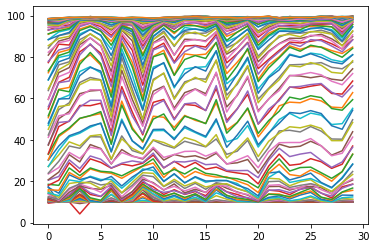

In [31]:
import matplotlib.pyplot as plt

plt.plot(acc_list)
plt.show()

In [ ]:
acc_list

In [ ]:
model.sc1.conv1.weight

In [ ]:
model.eval()

In [ ]:
len(trainloader)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(total,correct,end='')

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
c1.size()[0]

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
labels

In [ ]:
output.size()

In [ ]:
c6.size()

In [ ]:
SIZED_VAL_PATH = 'sized_val'

new_path = []

for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

#new_path

In [ ]:
new_path.sort(key=lambda x:int(x[0].split('/')[1]))
new_path

In [ ]:
val_gen_arr = []
for i in tqdm(range(len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8,
                                            pin_memory=True)
    val_gen_arr.append(testloader)

In [ ]:
#val_gen_arr

In [ ]:
accuracy = []

for testloader in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader:
            c1 = images[0][0].to(device)
            c2 = images[1][0].to(device)
            c3 = images[2][0].to(device)
            c4 = images[3][0].to(device)
            c5 = images[4][0].to(device)
            val_labels = images[0][1].to(device)
            outputs = model(c1,c2,c3,c4,c5)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
            #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    accuracy.append((100 * correct / total))

In [ ]:
for i in range(len(accuracy)):
    print(i,accuracy[i])

In [ ]:
for i in range(len(accuracy)):
    print(accuracy[i],',',end='')

In [ ]:
torch.save(model.state_dict(),'deepscln_jan20.pt')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.show()

In [ ]:
import csv

csvfile = open('test.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in [accuracy]:
    csvwriter.writerow(row)
    
csvfile.close()